In [1]:
import os
import sys
import subprocess
import datetime as dt
import itertools
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
import dask.array as da
import matplotlib.pyplot as plt
import cmocean
from MHW_daily_calcs import *

#### Calculate equivalent SST thresholds that applied to raw SST to see if they are smooth in time

### non-detrended case is simpler so start there

In [2]:
climyrs=[1993,2023]
qtile=0.90

In [3]:
flistclim = [fnameCanESMClim(workdir,climyrs[0],climyrs[-1],mm) for mm in range(1,13)]
fclim=xr.open_mfdataset(flistclim,combine='nested',concat_dim='month',parallel=True,decode_times=False)

In [4]:
flistthresh=[[fnameCanESMAnomQtile(workdir, climyrs[0],climyrs[-1], ilead, yind, qtile) for yind in [0,60,120]] for ilead in range(0,215)]
fthr=xr.open_mfdataset(flistthresh,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)

In [5]:
fthr

<xarray.Dataset> Size: 1GB
Dimensions:   (leadtime: 215, month: 12, lat: 180, lon: 360)
Coordinates:
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * leadtime  (leadtime) float64 2kB 15.0 39.0 63.0 ... 5.127e+03 5.151e+03
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * month     (month) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    qt        (leadtime, month, lat, lon) float64 1GB dask.array<chunksize=(1, 12, 60, 360), meta=np.ndarray>

(0.0, 366.0)

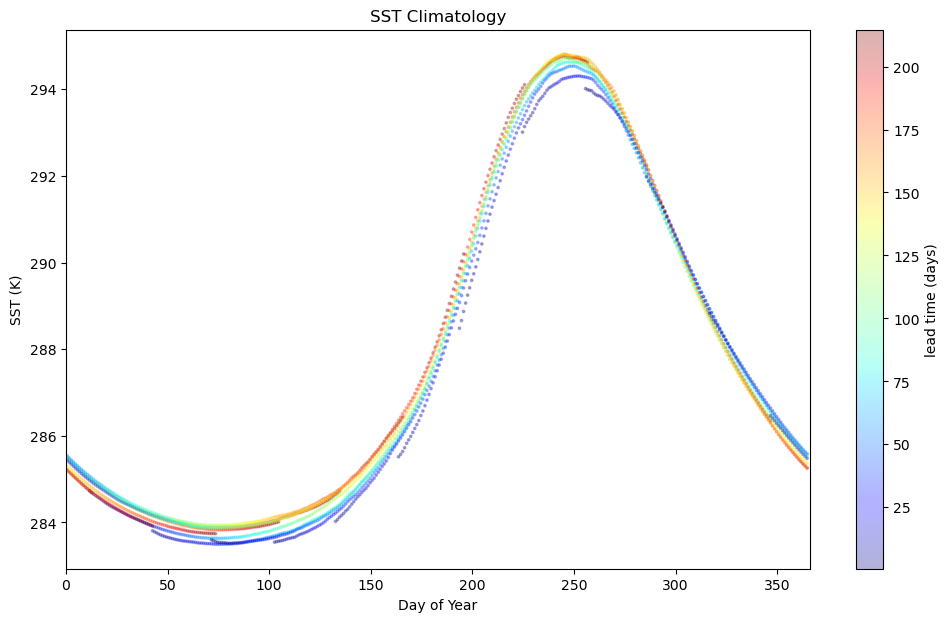

In [6]:
#clim only
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,21)).total_seconds()/(24*3600)+fthr.leadtime.values/24
    t=t%365
    m=ax.scatter(t,fclim.tso.isel(month=mm-1,lat=130,lon=200).values,c=fthr.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Climatology')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

(0.0, 366.0)

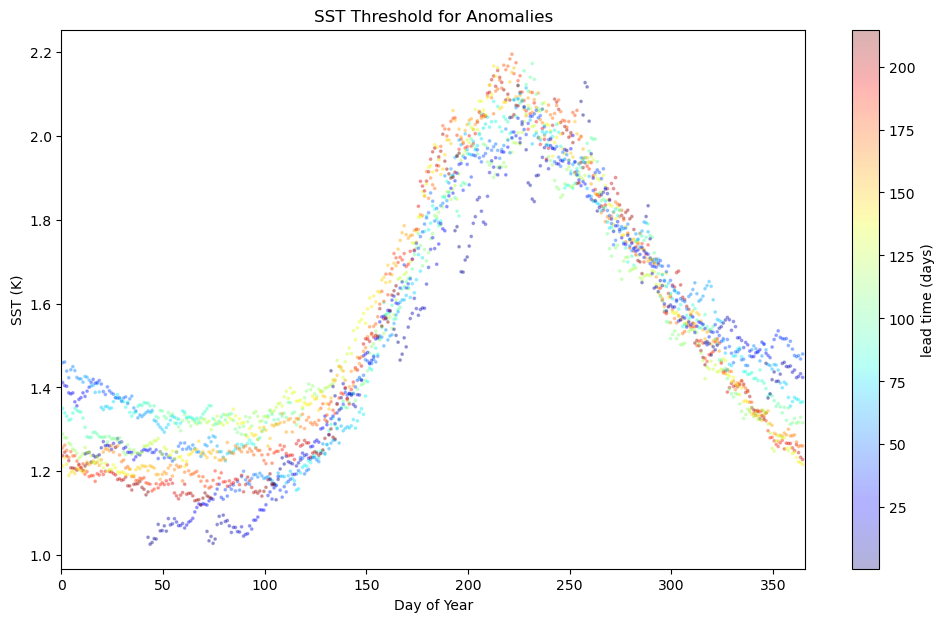

In [7]:
#threshold only
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,21)).total_seconds()/(24*3600)+fthr.leadtime.values/24
    t=t%365
    m=ax.scatter(t,fthr.qt.isel(month=mm-1,lat=130,lon=200),c=fthr.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Threshold for Anomalies')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

(0.0, 366.0)

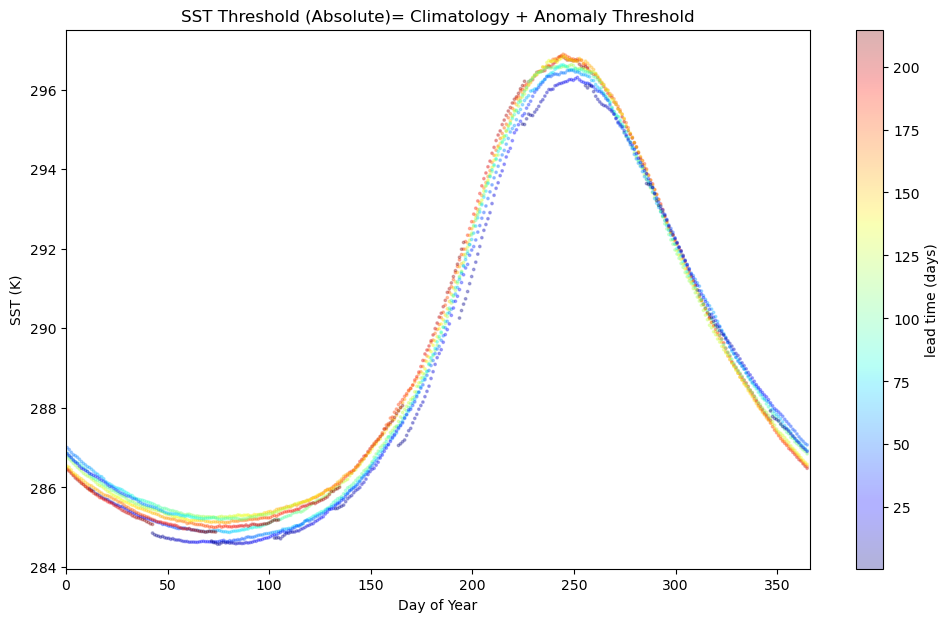

In [8]:
# both
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,21)).total_seconds()/(24*3600)+fthr.leadtime.values/24
    t=t%365
    m=ax.scatter(t,fclim.tso.isel(month=mm-1,lat=130,lon=200).values+fthr.qt.isel(month=mm-1,lat=130,lon=200),c=fthr.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Threshold (Absolute)= Climatology + Anomaly Threshold')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

### now detrended version

first check trends

In [9]:
flistb=[[fnameCanESMDetrFitByLead(workdir, climyrs[0],climyrs[-1], ilead, yind) for yind in [0,60,120]] for ilead in range(0,215)]
fb=xr.open_mfdataset(flistb,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)

In [10]:
fb.leadtime

<xarray.DataArray 'leadtime' (leadtime: 215)> Size: 2kB
array([  0,   1,   2, ..., 212, 213, 214])
Dimensions without coordinates: leadtime

(0.0, 215.0)

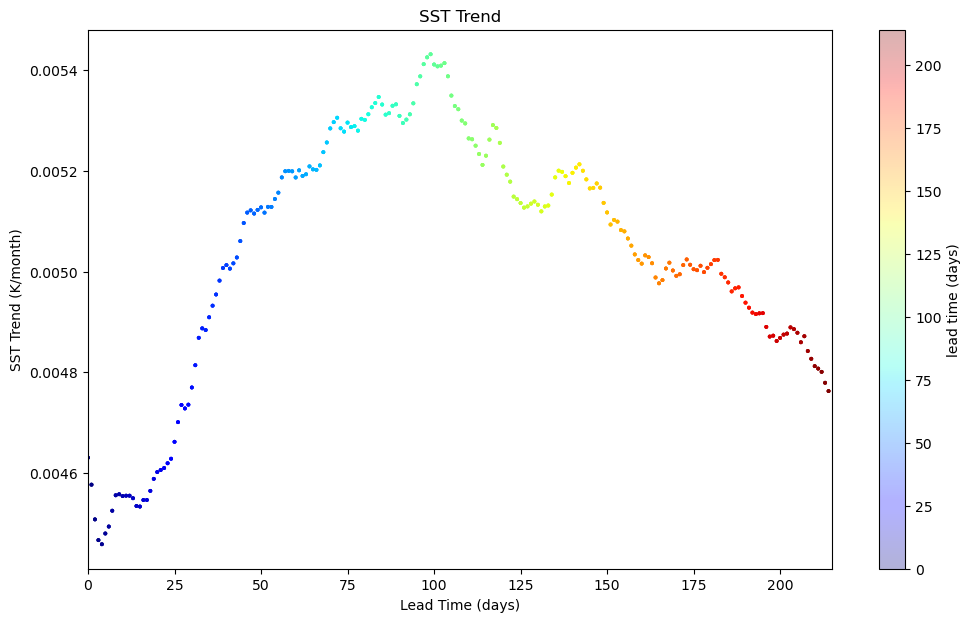

In [11]:
# trend only
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=fb.leadtime.values # already in days in this file
    m=ax.scatter(t,fb.fit.isel(b=1,lat=130,lon=200),c=fb.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Trend')
ax.set_xlabel('Lead Time (days)')
ax.set_ylabel('SST Trend (K/month)')
ax.set_xlim(0,215)

(0.0, 366.0)

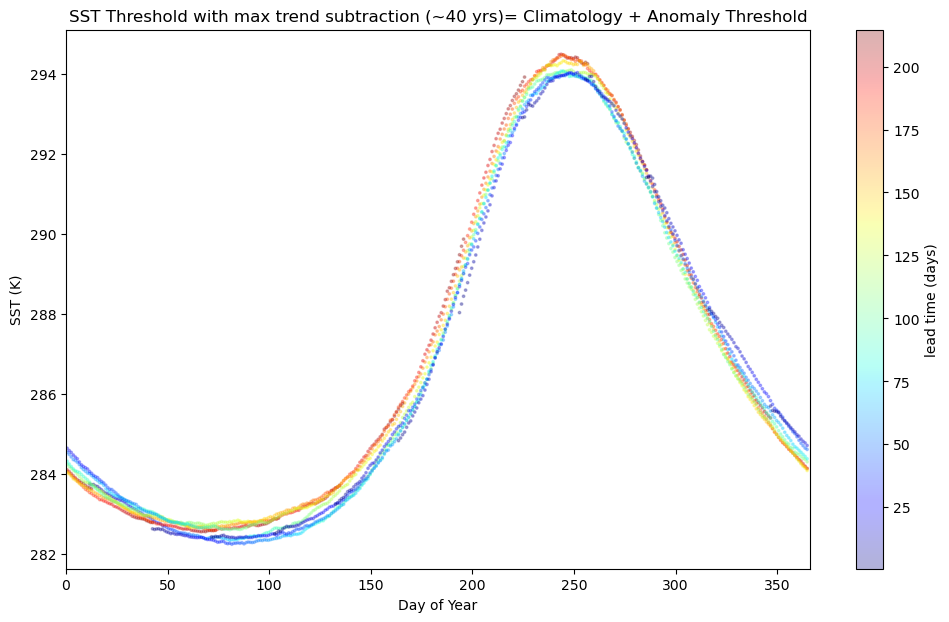

In [12]:
# ball: clim + qt + max adjustment due to trend (overestimate)
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,21)).total_seconds()/(24*3600)+fthr.leadtime.values/24
    t=t%365
    m=ax.scatter(t,fclim.tso.isel(month=mm-1,lat=130,lon=200).values+fthr.qt.isel(month=mm-1,lat=130,lon=200)-fb.fit.isel(b=1,lat=130,lon=200).values*(40*12),c=fthr.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Threshold with max trend subtraction (~40 yrs)= Climatology + Anomaly Threshold')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

In [13]:
fb.close(); fclim.close(); 
fthr.close()

### Check resulting fraction of MHW days at each site

NOTE: FREQUENCY OF MHWS IS NOT 10% AT ALL SITES BECAUSE THRESHOLDS APPLIED TO EACH INDIVIDUAL MONTH ARE CALCULATED FROM THAT MONTH PLUS THE PRECEEDING AND FOLLOWING MONTH; 10% FREQUENCY IS NOT GUARANTEED BY THIS PROCEEDURE

no detrend

In [14]:
vals=[]
for ilead in range(0,215):
    flistMHW=[fnameCanESMMHW(workdir, climyrs[0],climyrs[-1], ilead, yind, qtile) for yind in [0,60,120]]
    fMHW=xr.open_mfdataset(flistMHW,combine='nested',concat_dim='lat',parallel=True,decode_times=False)
    vals.append(fMHW.MHW_prob.sum(dim='reftime').values.flatten()/len(fMHW.reftime.values)*100)
    fMHW.close()
vals0=np.concatenate(vals,axis=0)
vals1=np.array(vals).reshape(215,180,360)

RuntimeError: NetCDF: Not a valid ID

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(9,2.5))
ax[0].hist(vals0[vals0>0],100);
ax[0].set_xlabel('Percent of Days with MHW Classification')
ax[0].set_ylabel('Number of series')
ax[0].set_title('Histogram')
cm1=cmocean.cm.balance
cm1.set_bad('gray')
m=ax[1].pcolormesh(vals1.mean(axis=0),vmin=7,vmax=13,cmap=cm1)
fig.colorbar(m)
ax[1].plot(180,20,'r.')

In [ ]:
# check calculations in a region with low % MHW
display(vals1[:,20,180])
display(vals1[110,20,180])
display(vals1[214,20,180])

In [ ]:
vals1.shape

In [ ]:
ilead=110
ilat=20
ilon=180
qtile=0.9
fanom=xr.open_dataset(fnameCanESMAnomByLead(workdir,climyrs[0],climyrs[-1], ilead, 0),
                      decode_times=False).isel(lat=ilat,lon=ilon)
fMHW=xr.open_dataset(fnameCanESMMHW(workdir,climyrs[0],climyrs[-1], ilead, 0,qtile),
                      decode_times=False).isel(lat=ilat,lon=ilon)
fQ=xr.open_dataset(fnameCanESMAnomQtile(workdir,climyrs[0],climyrs[-1], ilead, 0,qtile),
                      decode_times=False).isel(lat=ilat,lon=ilon)

In [ ]:
anoms=fanom.sst_an.data
qv=np.quantile(anoms.flatten(),.9)
display(qv);display(fQ.qt.values)

In [ ]:
np.sum(anoms>qv,axis=0)/len(anoms),np.mean(np.sum(anoms>qv,axis=0)/len(anoms))

detrend

In [ ]:
vals=[]
for ilead in range(0,215):
    flistMHW=[fnameCanESMMHWDetr(workdir, climyrs[0],climyrs[-1], ilead, yind, qtile) for yind in [0,60,120]]
    fMHW=xr.open_mfdataset(flistMHW,combine='nested',concat_dim='lat',parallel=True,decode_times=False)
    vals.append(fMHW.MHW_prob.sum(dim='reftime').values.flatten()/len(fMHW.reftime.values)*100)
    fMHW.close()
vals0=np.concatenate(vals,axis=0)
vals1=np.array(vals).reshape(215,180,360)

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(9,2.5))
ax[0].hist(vals0[vals0>0],100);
ax[0].set_xlabel('Percent of Days with MHW Classification')
ax[0].set_ylabel('Number of series')
ax[0].set_title('Histogram')
cm1=cmocean.cm.balance
cm1.set_bad('gray')
m=ax[1].pcolormesh(vals1.mean(axis=0),vmin=7,vmax=13,cmap=cm1)
fig.colorbar(m)
ax[1].plot(211,16,'r.')

In [ ]:
display(vals1[:,17,178])
display(vals1[214,17,178])

In [ ]:
display(vals1[:,16,211])
display(vals1[214,16,211])

## possible approach to smoothing: filter original sst series, then redo calculations?